In [1]:
#https://www.kaggle.com/psvishnu/forestfire-impact-prediction-stats-and-ml
!nvidia-smi

Wed Sep  9 11:21:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import zscore
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
# path = 'forestfires.csv'
path = "forestfires.csv"
df = pd.read_csv(path)

df.shape

(517, 13)

In [4]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [5]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [7]:
df.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [8]:
plt.rcParams["figure.figsize"] = 10,6

SKew : 12.846933533934868
Kurtosis:194.1407210942299


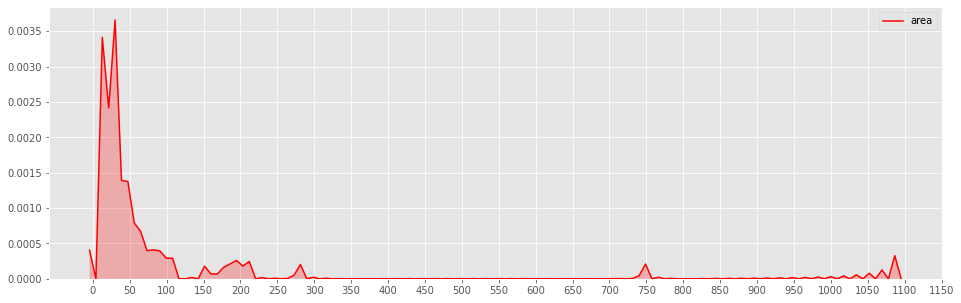

In [9]:
target='area'
plt.figure(figsize=(16,5))
print("SKew : {}".format(df[target].skew()))
print("Kurtosis:{}".format(df[target].kurtosis()))
ax = sns.kdeplot(df[target], shade=True, color='r')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

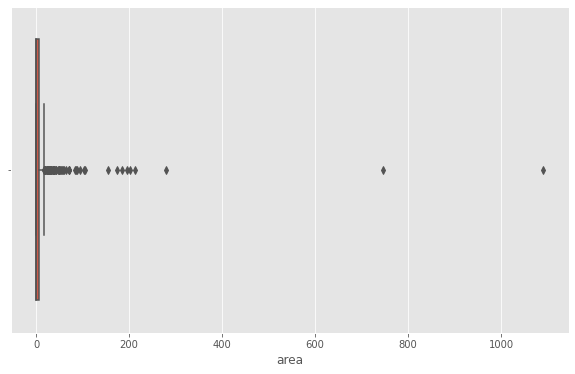

In [10]:
ax = sns.boxplot(df[target])

In [11]:
# Outlier points
y_outliers = df[abs(zscore(df[target])) >= 3 ]
y_outliers

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


In [12]:
dfa = df.drop(columns=target)
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()

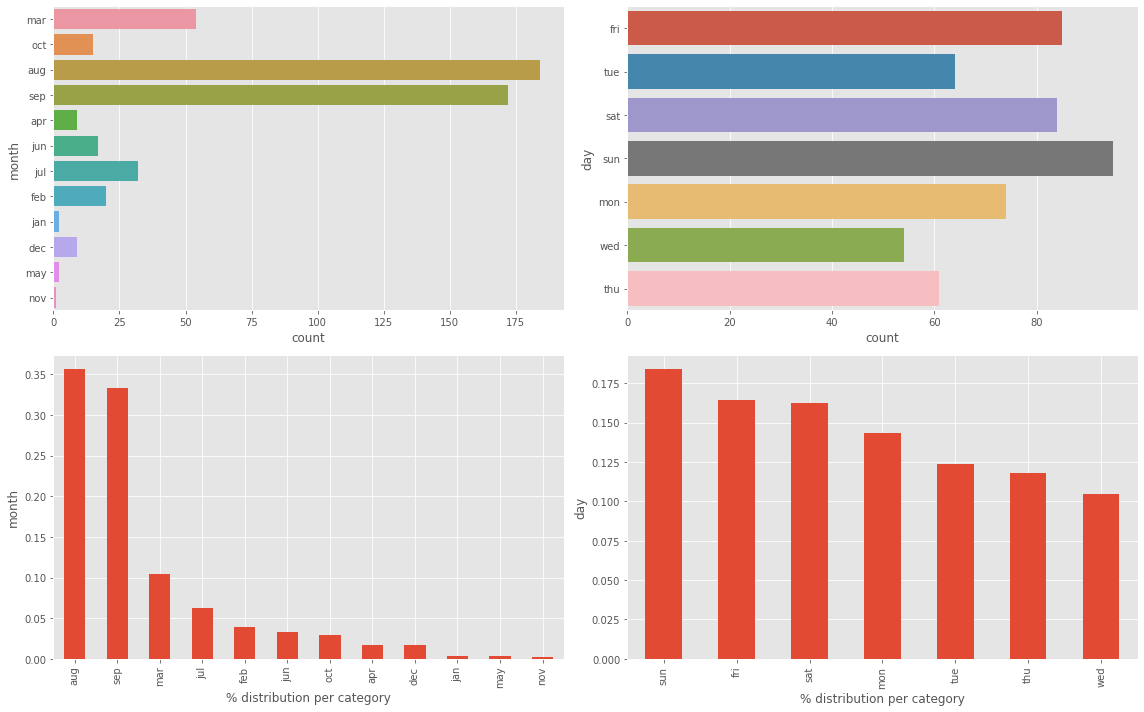

In [13]:
plt.figure(figsize=(16,10))
for i, col in enumerate(cat_columns, 1):
  plt.subplot(2,2,i)
  sns.countplot(data=dfa, y = col)
  plt.subplot(2,2,i+2)
  df[col].value_counts(normalize=True).plot.bar()
  plt.ylabel(col)
  plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

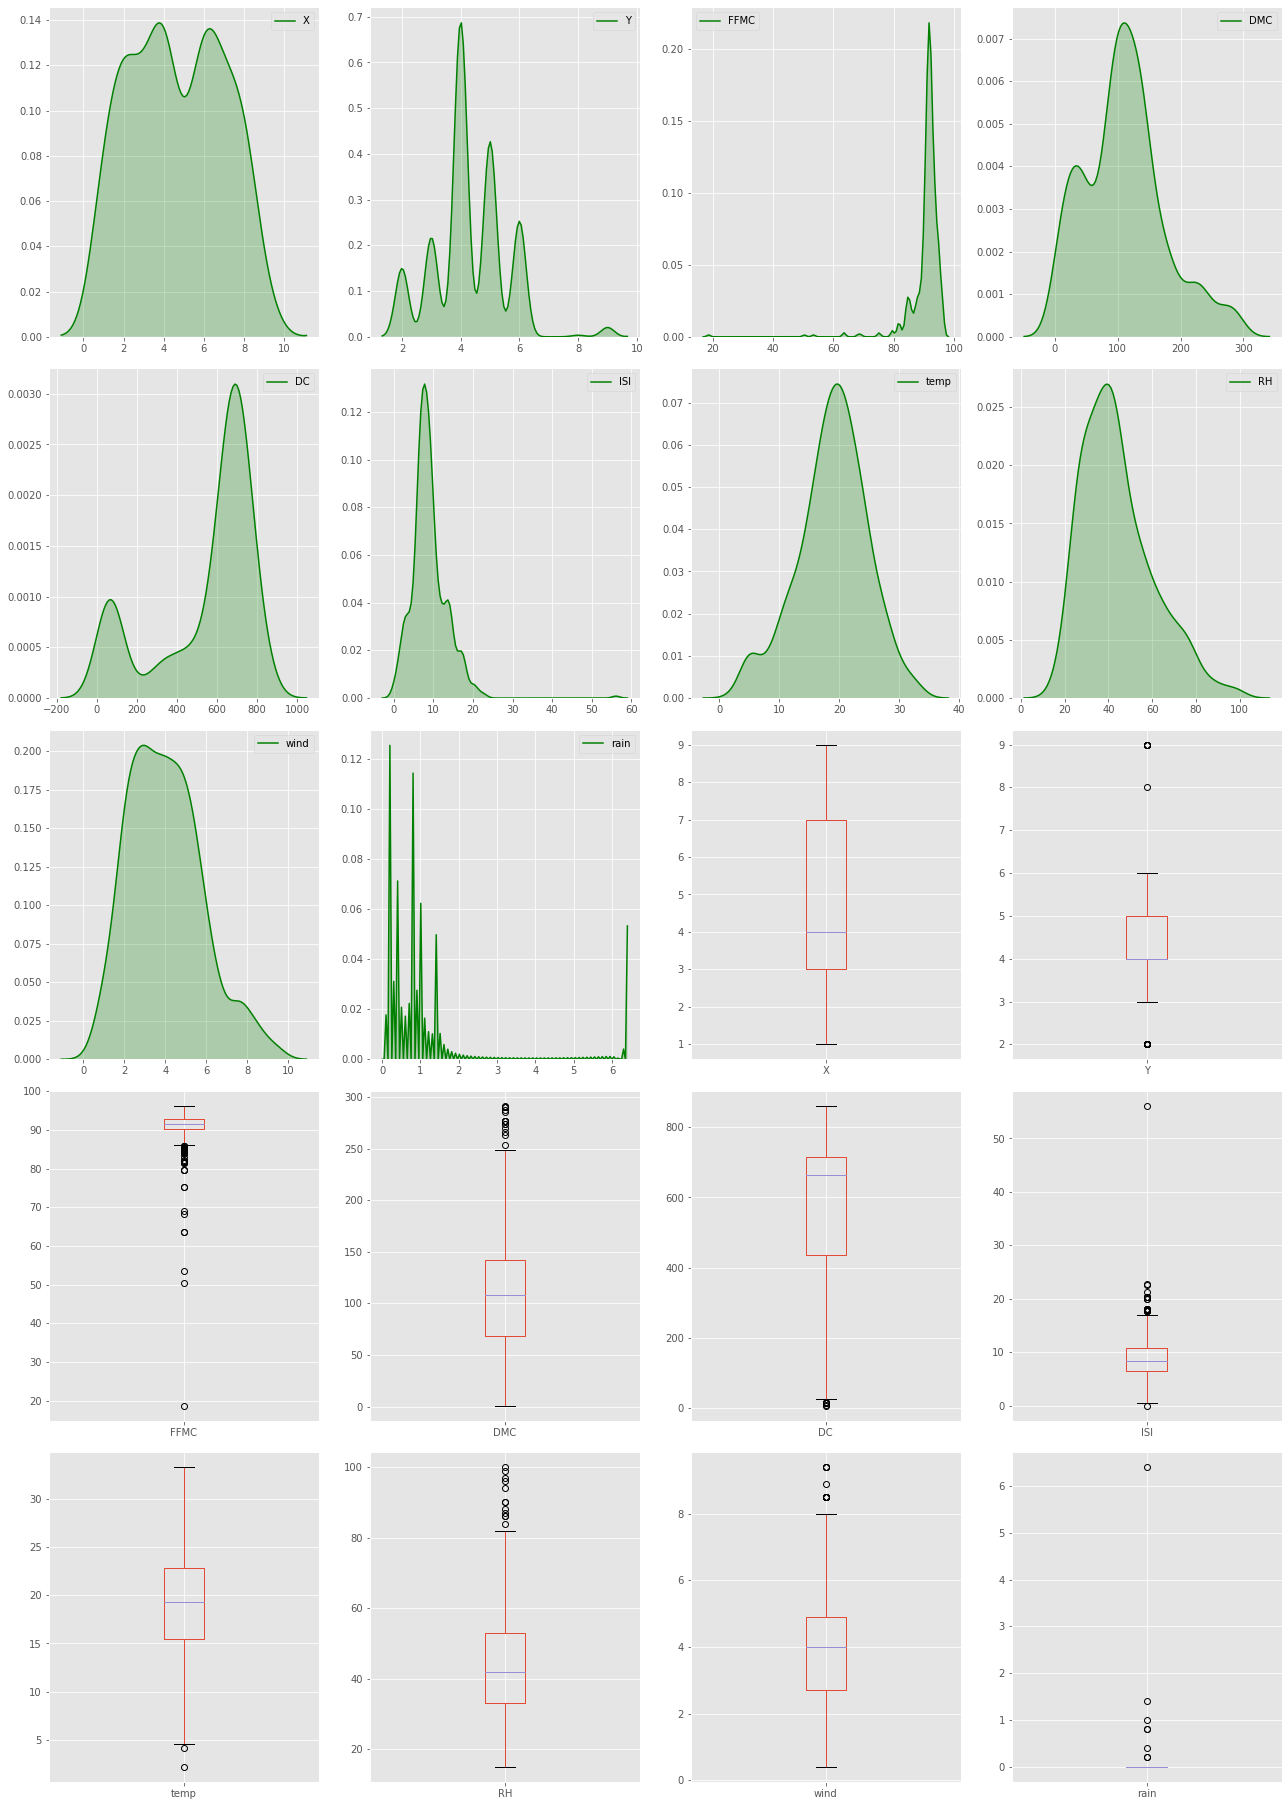

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,0.036246,0.417296,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,-1.172331,1.420553,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


In [14]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])


In [16]:
print(df['area'].describe(),'\n')
print(y_outliers)

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain     area
237  1  2   sep  tue  91.0  129.5  692.6   7.0  18.8  40   2.2   0.0   212.88
238  6  5   sep  sat  92.5  121.1  674.4   8.6  25.1  27   4.0   0.0  1090.84
415  8  6   aug  thu  94.8  222.4  698.6  13.9  27.5  27   4.9   0.0   746.28
479  7  4   jul  mon  89.2  103.9  431.6   6.4  22.6  57   4.9   0.0   278.53


In [18]:
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No damage


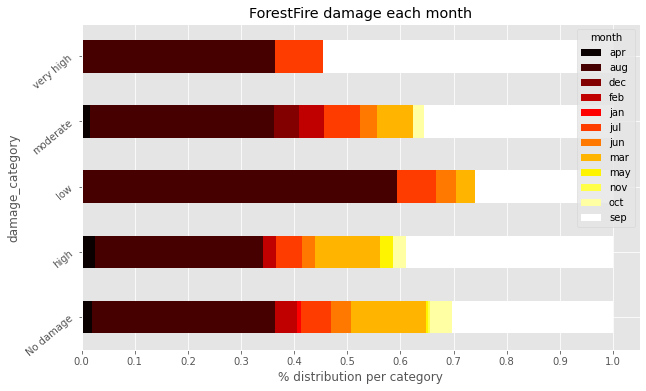

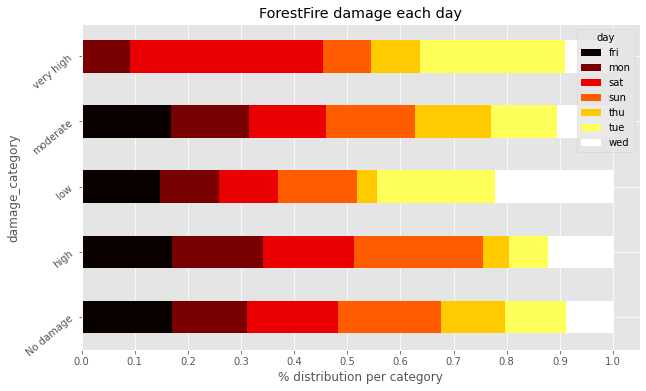

In [19]:
for col in cat_columns:
  cross = pd.crosstab(index=df['damage_category'], columns=df[col], normalize='index')
  cross.plot.barh(stacked=True, rot=40,cmap='hot')
  plt.xlabel('% distribution per category')
  plt.xticks(np.arange(0,1.1,0.1))
  plt.title('ForestFire damage each {}'.format(col))
plt.show()

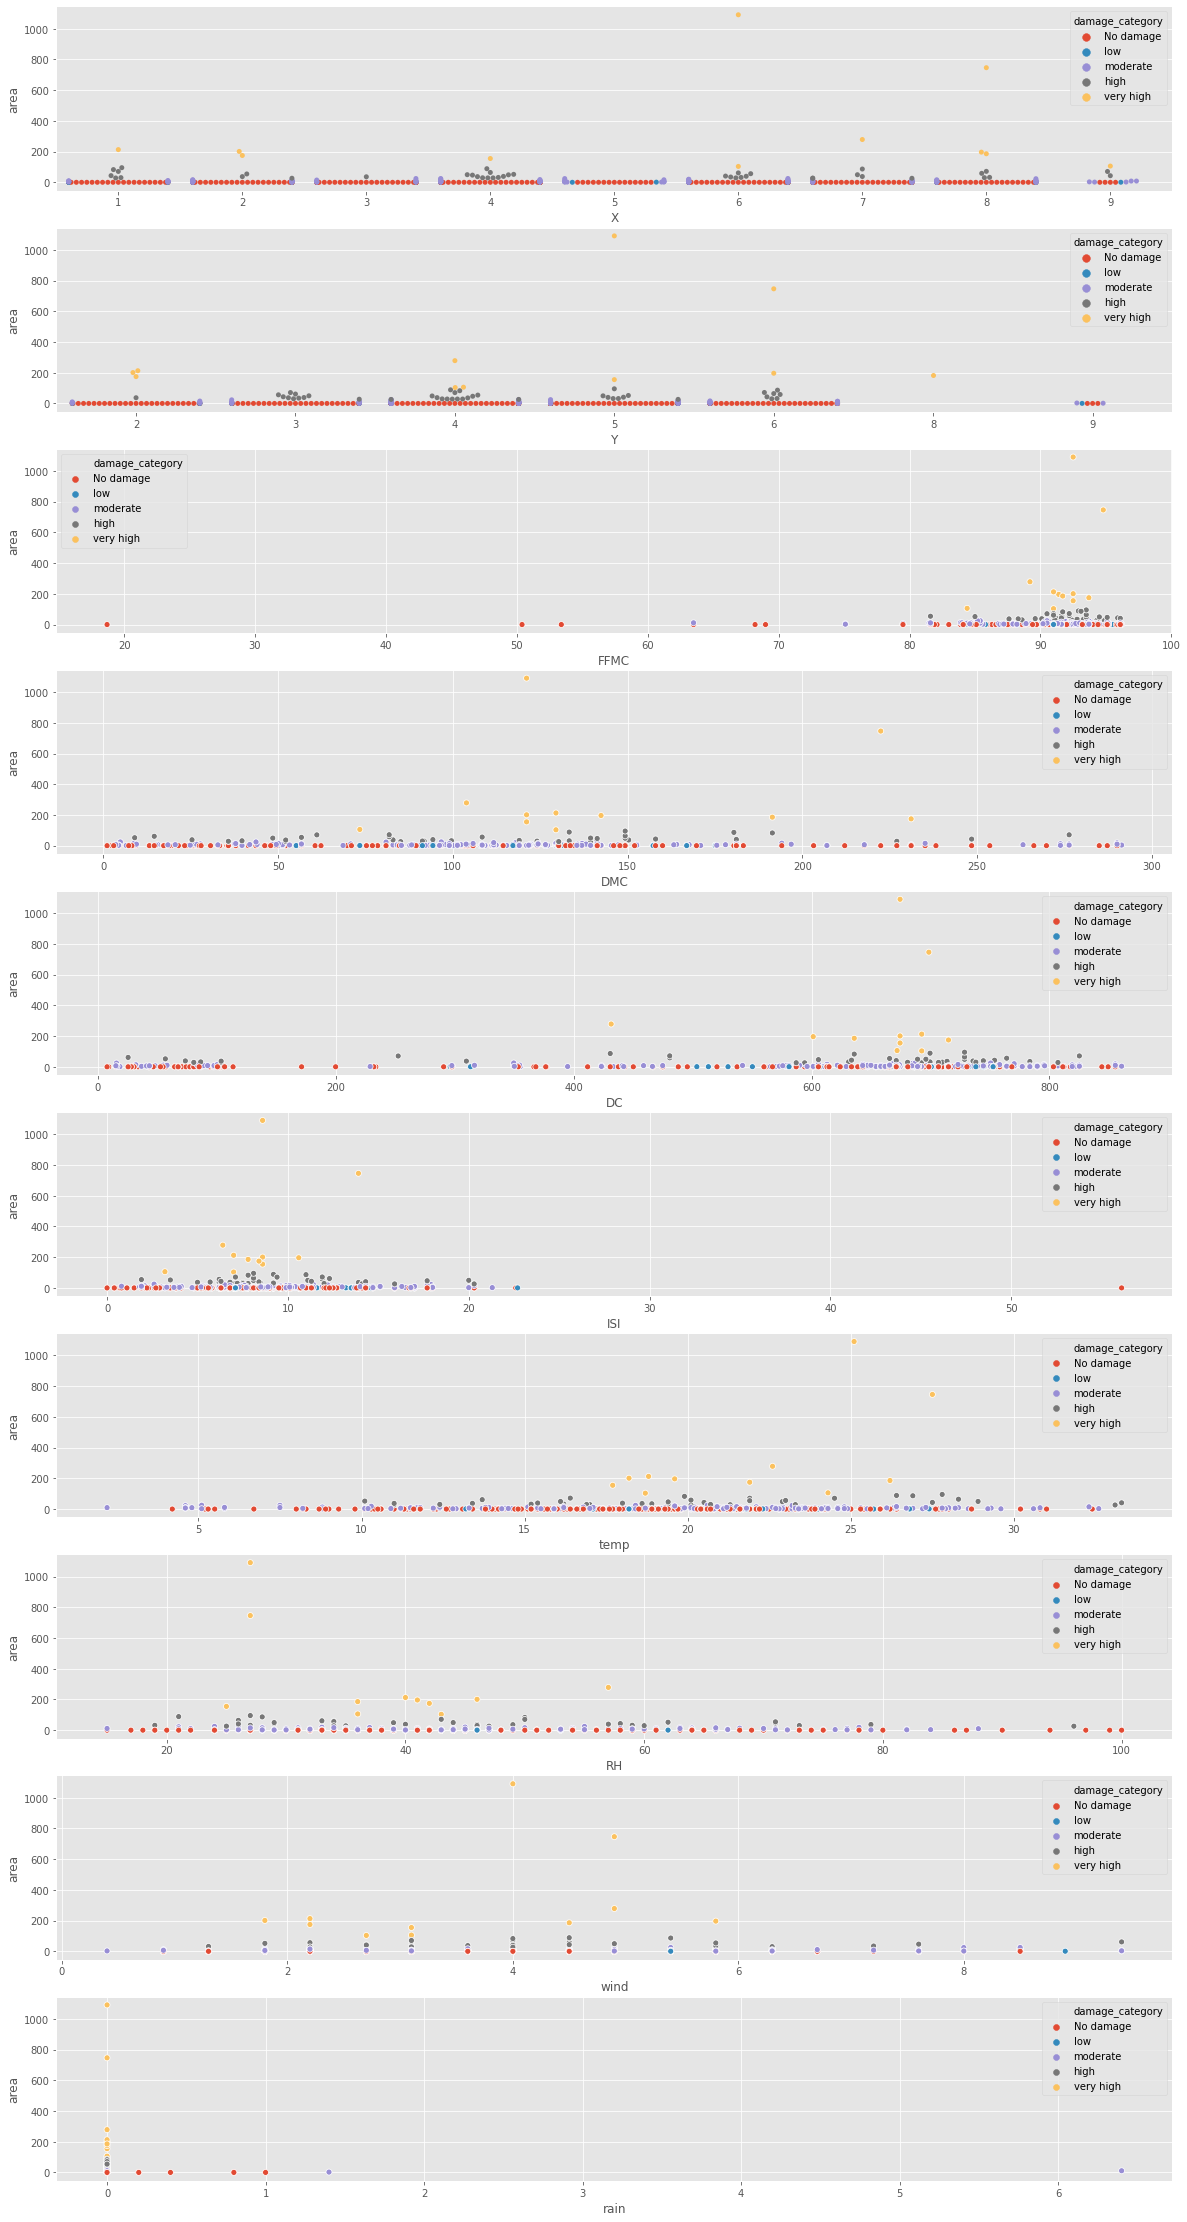

In [20]:
plt.figure(figsize=(20,40))
for i, col in enumerate(num_columns, 1):
  plt.subplot(10,1,i)
  if col in ['X', 'Y']:
    sns.swarmplot(data=df,x=col, y=target,hue='damage_category')
  else:
    sns.scatterplot(data=df, x=col, y=target, hue='damage_category')
plt.show()



In [21]:
selected_features = df.drop(columns=['damage_category','day','month']).columns
selected_features

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area'],
      dtype='object')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


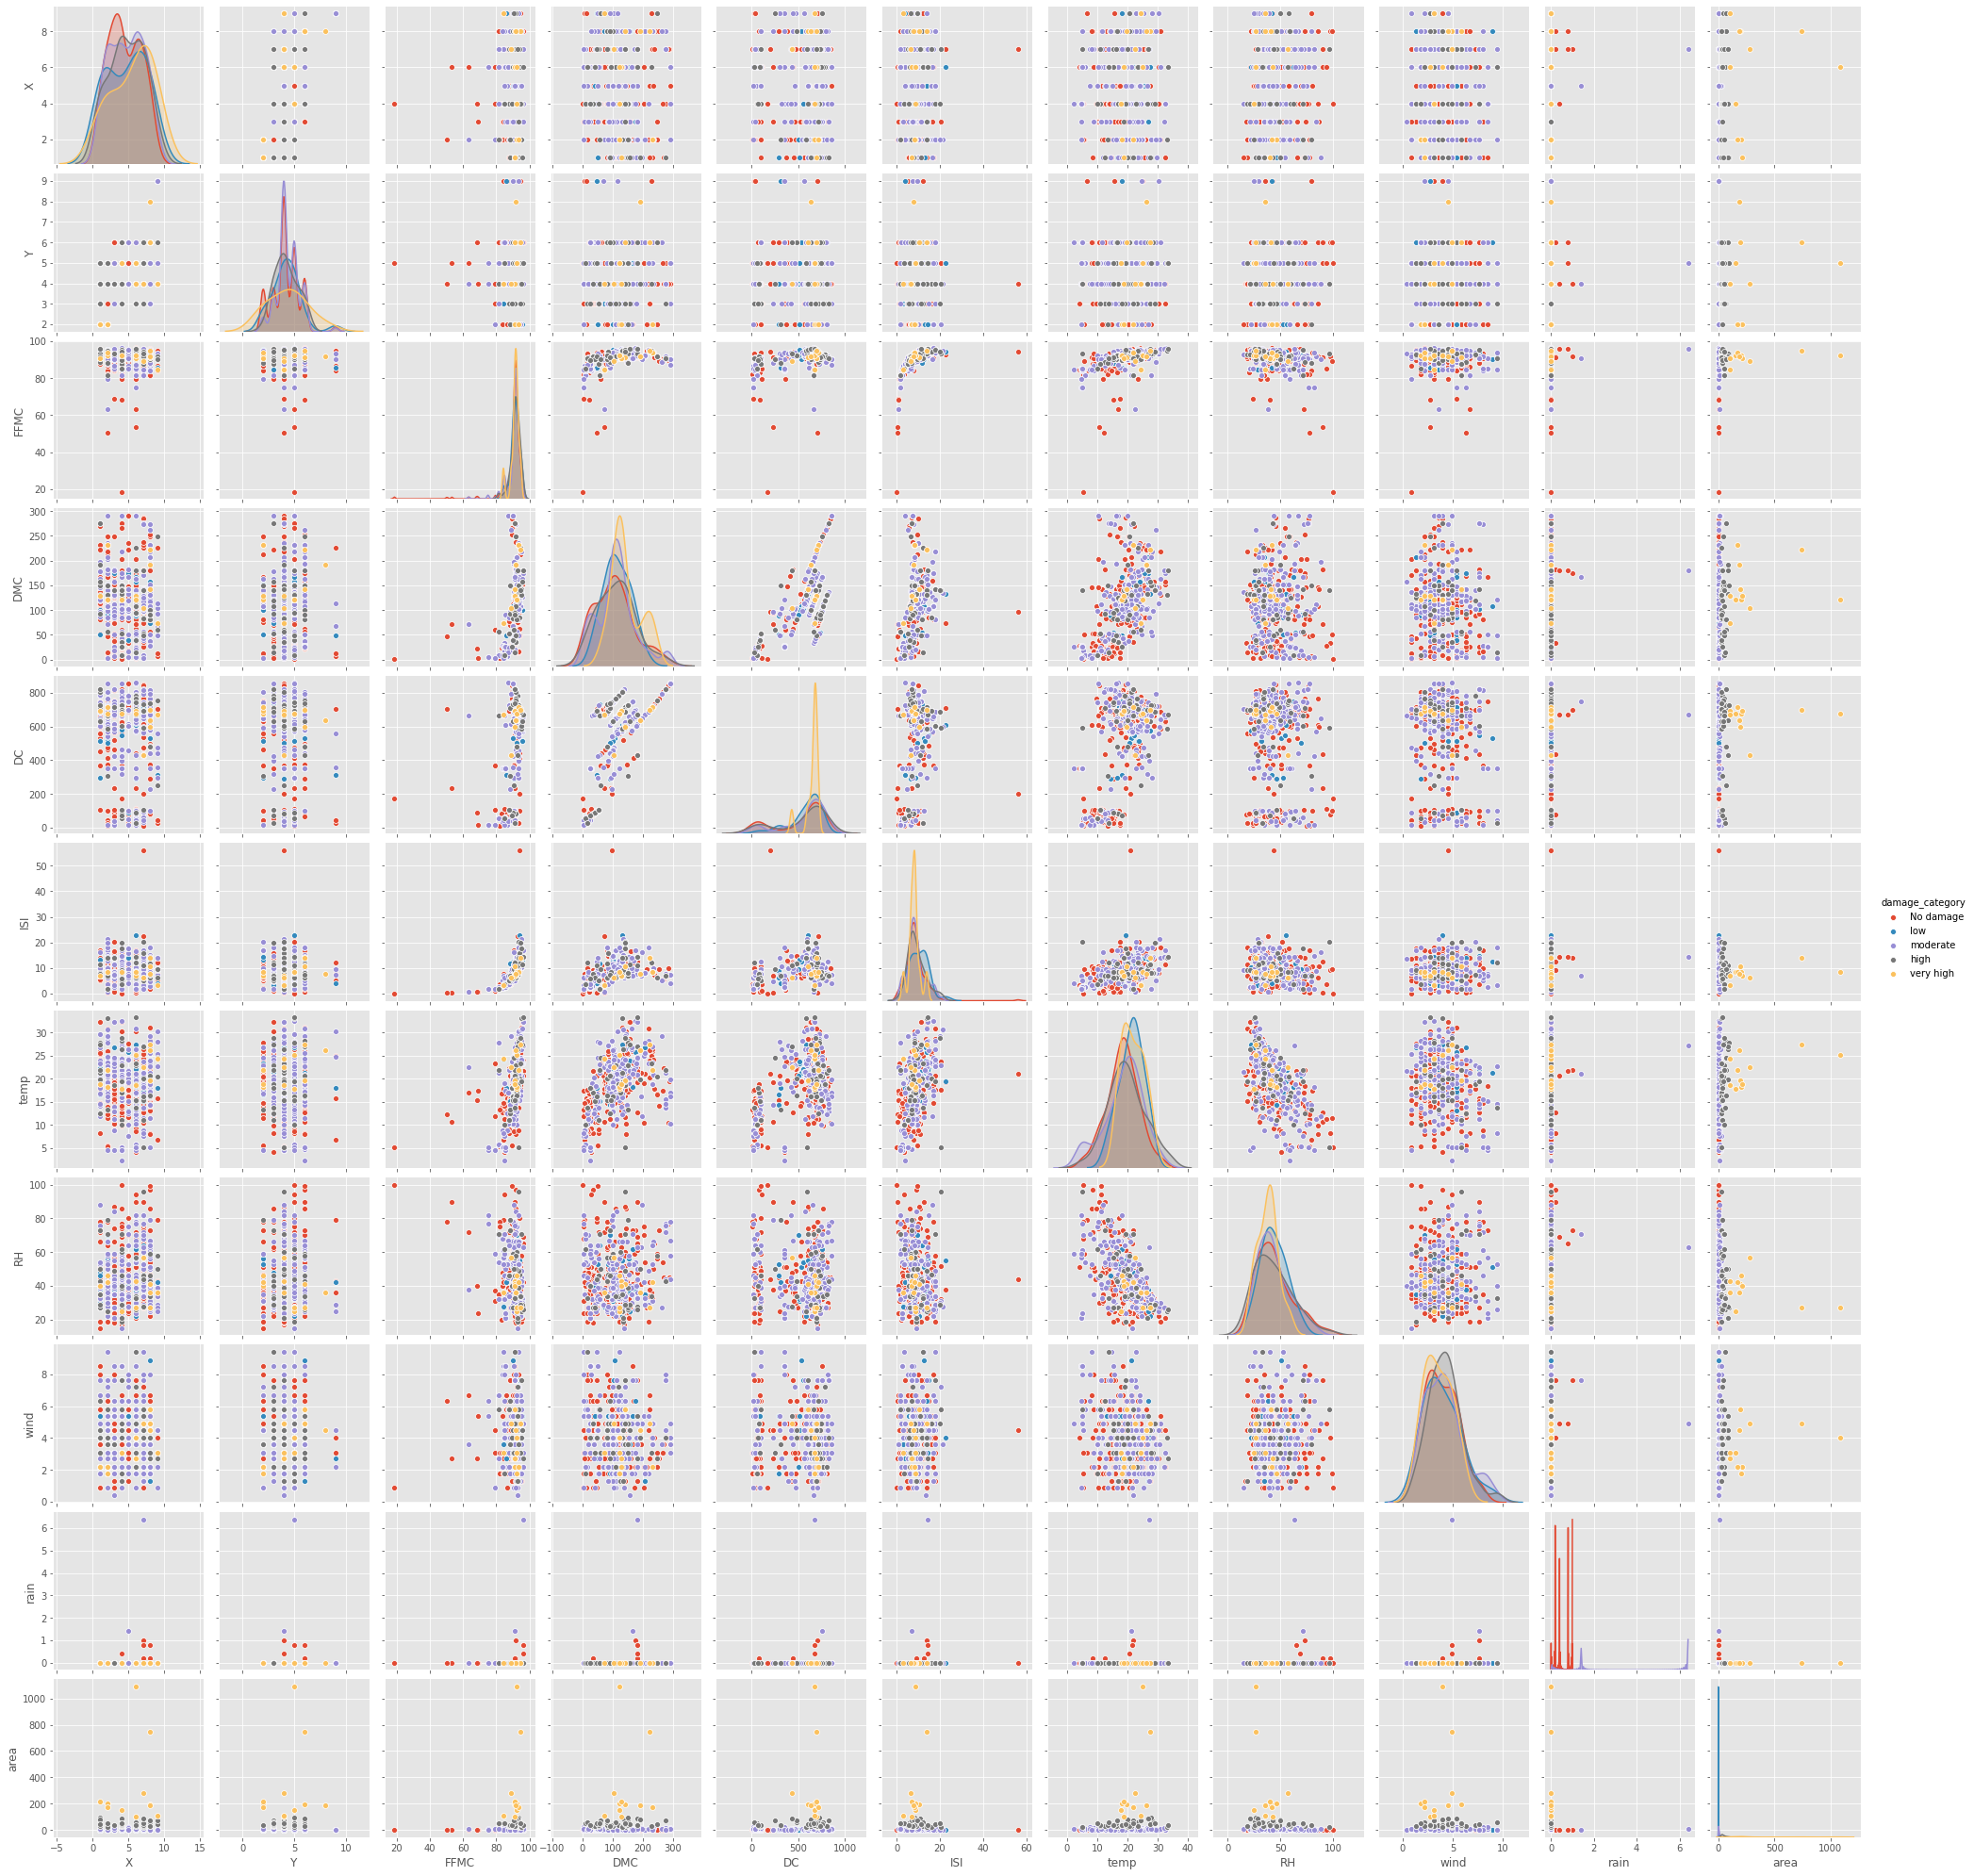

In [22]:
sns.pairplot(df, hue='damage_category', vars=selected_features)
plt.show()

In [23]:
out_columns = ['area','FFMC','ISI','rain']

In [25]:
df = pd.get_dummies(df, columns=['day', 'month'], drop_first=True)

In [27]:
print(df[out_columns].describe().T)

      count       mean        std   min   25%    50%    75%      max
area  517.0  12.847292  63.655818   0.0   0.0   0.52   6.57  1090.84
FFMC  517.0  90.644681   5.520111  18.7  90.2  91.60  92.90    96.20
ISI   517.0   9.021663   4.559477   0.0   6.5   8.40  10.80    56.10
rain  517.0   0.021663   0.295959   0.0   0.0   0.00   0.00     6.40


In [32]:
print(np.log1p(df[out_columns]).skew())
print("''''''''''''''''")
np.log1p(df[out_columns]).kurtosis()

area     1.217838
FFMC   -11.675394
ISI     -0.937218
rain    14.173028
dtype: float64
''''''''''''''''


area      0.945668
FFMC    185.482383
ISI       2.584588
rain    234.240025
dtype: float64

In [34]:
mask = df.loc[:,['FFMC']].apply(zscore).abs() < 3
df['rain'] = df['rain'].apply(lambda x: int(x > 0.0))

In [35]:
df = df[mask.values]
df.shape

(510, 29)

In [36]:
out_columns.remove('rain')
df[out_columns] = np.log1p(df[out_columns])

In [37]:
df[out_columns].skew()

area    1.208492
FFMC   -1.803993
ISI    -0.434372
dtype: float64

In [38]:
# we will use this dataframe for building our ML model
df_ml = df.drop(columns=['damage_category']).copy()

In [39]:
df_ml.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,7,5,4.468204,26.2,94.3,1.808289,8.2,51,6.7,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,7,4,4.517431,35.4,669.1,2.041220,18.0,33,0.9,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,7,4,4.517431,43.7,686.9,2.041220,14.6,33,1.3,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,8,6,4.529368,33.3,77.5,2.302585,8.3,97,4.0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,8,6,4.503137,51.3,102.2,2.360854,11.4,99,1.8,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [40]:
X = df.drop(columns=['area','damage_category'])
y = df['area']

In [41]:
X_constant = sm.add_constant(X)

,const,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,1.0,7,5,4.468204,26.2,94.3,1.808289,8.2,51,6.7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1.0,7,4,4.517431,35.4,669.1,2.041220,18.0,33,0.9,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,1.0,7,4,4.517431,43.7,686.9,2.041220,14.6,33,1.3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1.0,8,6,4.529368,33.3,77.5,2.302585,8.3,97,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1.0,8,6,4.503137,51.3,102.2,2.360854,11.4,99,1.8,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,1.0,4,3,4.414010,56.7,665.6,1.064711,27.8,32,2.7,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
513,1.0,2,4,4.414010,56.7,665.6,1.064711,21.9,71,5.8,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
514,1.0,7,4,4.414010,56.7,665.6,1.064711,21.2,70,6.7,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
515,1.0,1,4,4.558079,146.0,614.7,2.509599,25.6,42,4.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [42]:
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.489
Date:                Wed, 09 Sep 2020   Prob (F-statistic):             0.0558
Time:                        11:52:11   Log-Likelihood:                -874.85
No. Observations:                 510   AIC:                             1806.
Df Residuals:                     482   BIC:                             1924.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3192     18.275      0.017      0.986     -35.590      36.228
X              0.0532      0.033      1.621      0.106      -0.011       0.118
Y             -0.0115      0.061     -0.187      0.852      -0.132       0.109
FFMC          -0.1061      4.160     -0.025      0.980      -8.280       8.068
DMC            0.0041      0.002      2.166      0.031       0.000       0.008
DC            -0.0019      0.001     -1.440      0.150      -0.004       0.001
ISI           -0.1039      0.290     -0.358      0.720      -0.674       0.466
temp           0.0443      0.023      1.964      0.050   -2.77e-05       0.089
RH             0.0041      0.007      0.624      0.533      -0.009       0.017
wind           0.0678      0.039      1.719      0.086      -0.010       0.145
rain          -0.9272      0.547     -1.695      0.091      -2.002       0.148
day_mon        0.1076      0.230      0.467      0.641      -0.345       0.560
day_sat        0.3312      0.222      1.493      0.136      -0.105       0.767
day_sun        0.1794      0.215      0.836      0.403      -0.242       0.601
day_thu        0.0714      0.243      0.294      0.769      -0.406       0.549
day_tue        0.3483      0.238      1.464      0.144      -0.119       0.816
day_wed        0.1960      0.248      0.791      0.429      -0.291       0.683
month_aug      0.2450      0.847      0.289      0.772      -1.419       1.909
month_dec      2.2223      0.804      2.764      0.006       0.643       3.802
month_feb      0.2217      0.568      0.391      0.696      -0.894       1.337
month_jan     -0.8605      1.483     -0.580      0.562      -3.775       2.054
month_jul      0.0319      0.731      0.044      0.965      -1.405       1.469
month_jun     -0.3316      0.679     -0.488      0.625      -1.666       1.002
month_mar     -0.2613      0.519     -0.503      0.615      -1.282       0.759
month_may      0.6256      1.106      0.565      0.572      -1.548       2.800
month_nov     -1.1779      1.490     -0.790      0.430      -4.106       1.750
month_oct      0.7718      1.005      0.768      0.443      -1.203       2.747
month_sep      0.8978      0.949      0.946      0.345      -0.967       2.762
==============================================================================
Omnibus:                       76.076   Durbin-Watson:                   0.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.018
Skew:                           1.074   Prob(JB):                     5.77e-24
Kurtosis:                       3.652   Cond. No.                     1.89e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+05. This might i

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:695: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


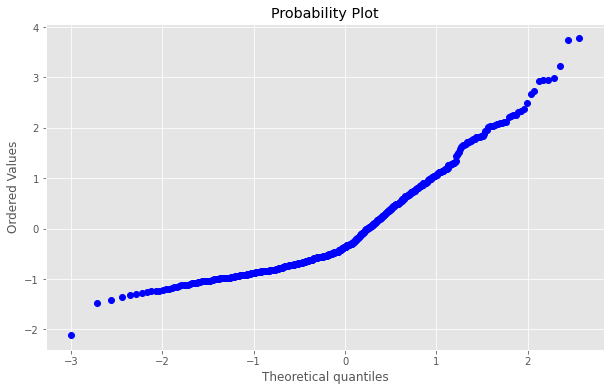

In [44]:
import scipy.stats as stats
import pylab

st_resid = lin_reg.get_influence().resid_studentized_internal
stats.probplot(st_resid, dist="norm", plot=pylab)
plt.show()

In [45]:
# return fstat and p-value
sm.stats.diagnostic.linear_rainbow(lin_reg)

(1.2832659161650857, 0.027048891500426286)

In [46]:
lin_reg.resid.mean()

9.756901169352846e-15

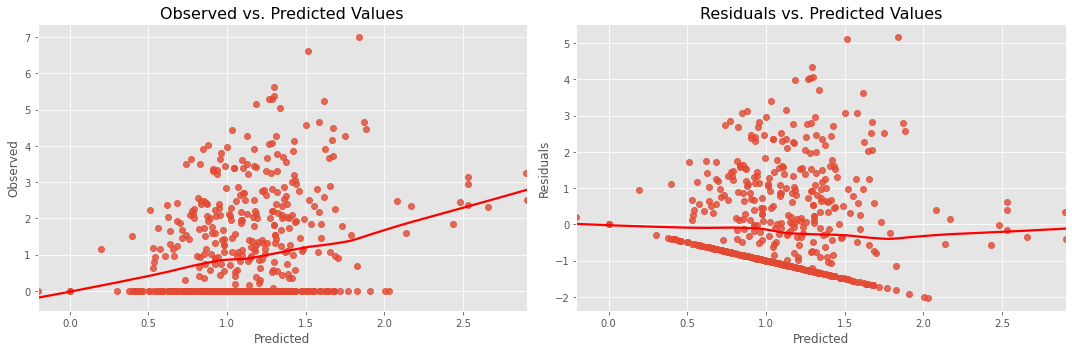

In [47]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(lin_reg, y) 
plt.tight_layout()

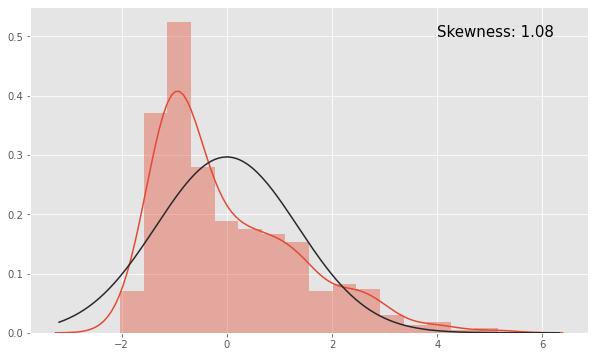

In [49]:
sns.distplot(lin_reg.resid,fit=stats.norm)
plt.text(4,0.5,f"Skewness: {round(lin_reg.resid.skew(),2)}",fontsize=15)
plt.show()

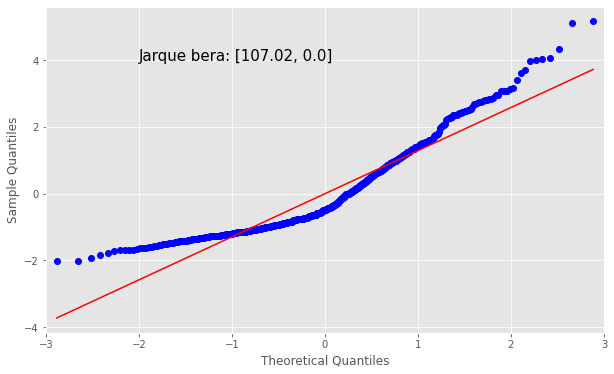

In [50]:
sm.qqplot(lin_reg.resid,line ='r')
jb = [round(n,2) for n in stats.jarque_bera(lin_reg.resid)]
plt.text(-2,4,f"Jarque bera: {jb}",fontsize=15)
plt.show()

In [51]:
sms.het_goldfeldquandt(lin_reg.resid, lin_reg.model.exog)

(0.9005330268628143, 0.7860123901512466, 'increasing')

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:695: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


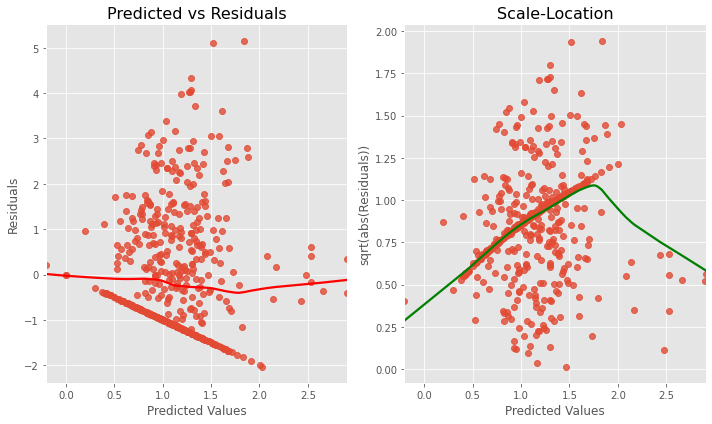

In [53]:
model = lin_reg
fitted_vals = model.predict()
resids = model.resid
resids_standardized = model.get_influence().resid_studentized_internal

fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Predicted vs Residuals', fontsize=16)
ax[0].set(xlabel='Predicted Values', ylabel='Residuals')

sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'green'})
ax[1].set_title('Scale-Location', fontsize=16)
ax[1].set(xlabel='Predicted Values', ylabel='sqrt(abs(Residuals))')

name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)
plt.tight_layout()

In [54]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(lin_reg.resid)


0.9793850110864487

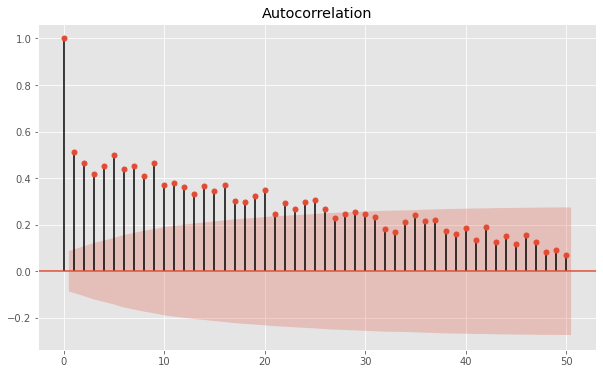

In [55]:
import statsmodels.tsa.api as smt
# Confidence intervals are drawn as a cone. 
# By default, this is set to a 95% confidence interval, 
# suggesting that correlation values outside of this code are very likely a correlation 
# and not a statistical fluke
acf = smt.graphics.plot_acf(lin_reg.resid, lags=50 , alpha=0.05)
acf.show()

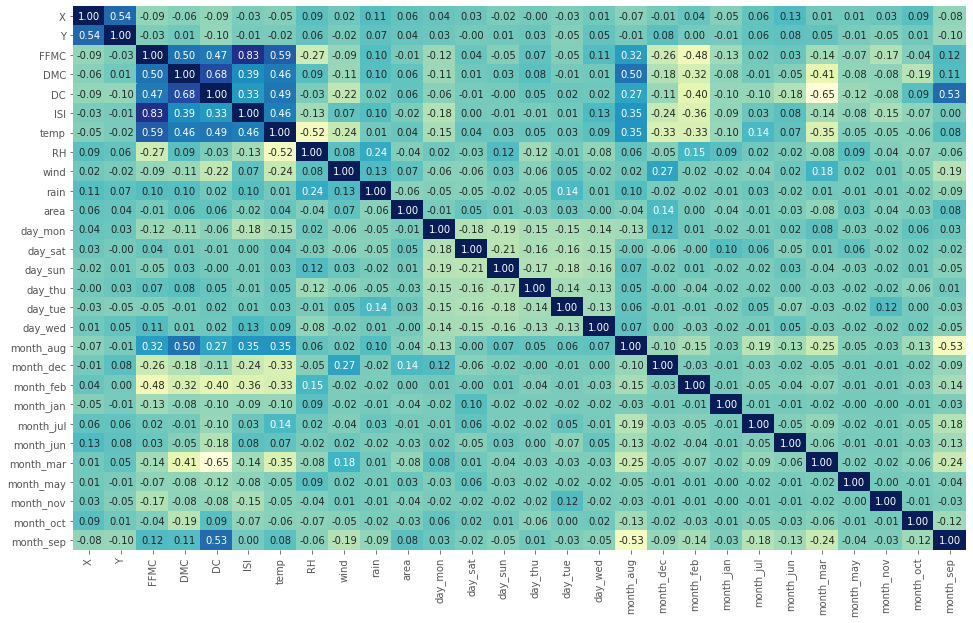

In [56]:
plt.figure(figsize =(16,10))

sns.heatmap(df.corr(),annot=True,cmap='YlGnBu',fmt=".2f",cbar=False)
plt.show()

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).sort_values(by="vif",ascending=False)

,vif
month_sep,53.307716
month_aug,43.939403
DC,26.792896
month_jul,8.378570
month_oct,7.681340
month_mar,6.694845
FFMC,5.629386
temp,4.535721
ISI,4.107793
DMC,3.978913


In [58]:
lr = LinearRegression()
lr.fit(X, y)

print(f'Intercept: {lr.intercept_}')
print(f'R^2 score: {lr.score(X, y)}')
pd.DataFrame({"Coefficients": lr.coef_}, index=X.columns)

Intercept: 0.31920683551524554
R^2 score: 0.0769861533829217


,Coefficients
X,0.053161
Y,-0.011457
FFMC,-0.106058
DMC,0.004149
DC,-0.001854
ISI,-0.103922
temp,0.044297
RH,0.004063
wind,0.067775
rain,-0.927225


In [59]:
X = df.drop(columns=['area','damage_category'])
y = df['area']

In [60]:
def check_stats(X,y):
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(pd.DataFrame({'vif': vif}, index=X.columns).sort_values(by="vif",ascending=False)[:10])
    lin_reg = sm.OLS(y,X).fit()
    print(lin_reg.summary())
check_stats(X,y)

                  vif
FFMC       202.334784
DC         159.585267
month_sep   77.976513
month_aug   67.081874
temp        53.012135
ISI         52.449380
RH          23.764931
Y           19.961996
DMC         15.417494
month_jul    8.764939
                                 OLS Regression Results                                
Dep. Variable:                   area   R-squared (uncentered):                   0.438
Model:                            OLS   Adj. R-squared (uncentered):              0.406
Method:                 Least Squares   F-statistic:                              13.92
Date:                Wed, 09 Sep 2020   Prob (F-statistic):                    7.32e-45
Time:                        12:57:21   Log-Likelihood:                         -874.85
No. Observations:                 510   AIC:                                      1804.
Df Residuals:                     483   BIC:                                      1918.
Df Model:                          27                 

In [61]:
X.drop(columns=['FFMC'],inplace=True)
# check_stats(X,y)


In [62]:
X.drop(columns=['Y'],inplace=True)
# check_stats(X,y)

In [63]:
X.drop(columns=['month_jul'],inplace=True)
# check_stats(X,y)

In [64]:
X.drop(columns=['day_thu'],inplace=True)
# check_stats(X,y)

In [65]:
X.drop(columns=['day_mon'],inplace=True)
# check_stats(X,y)

In [66]:
X.drop(columns=['month_aug'],inplace=True)
check_stats(X,y)

                 vif
DC         57.707223
ISI        38.292380
temp       27.680452
DMC        13.223716
RH         12.130774
wind        7.359276
X           5.267220
month_sep   3.915822
month_mar   2.741742
month_feb   1.631273
                                 OLS Regression Results                                
Dep. Variable:                   area   R-squared (uncentered):                   0.437
Model:                            OLS   Adj. R-squared (uncentered):              0.413
Method:                 Least Squares   F-statistic:                              18.07
Date:                Wed, 09 Sep 2020   Prob (F-statistic):                    2.20e-48
Time:                        12:58:35   Log-Likelihood:                         -875.21
No. Observations:                 510   AIC:                                      1792.
Df Residuals:                     489   BIC:                                      1881.
Df Model:                          21                            

In [67]:
X_m, y_m = df_ml.drop(columns=[target]), df_ml[target]

Out of 27 features, best number of features 1


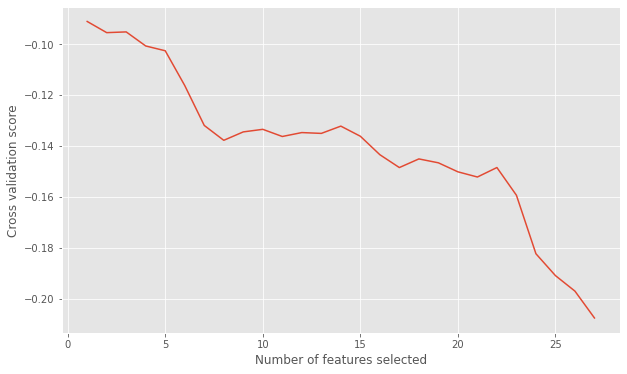

In [68]:
# RFECV is a variant with inbuilt Cross validation
model = LinearRegression()
selector = RFECV(model,cv=5)
selector = selector.fit(X_m, y_m)
print(f"Out of {len(X_m.columns)} features, best number of features {selector.n_features_}")
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(X_m.columns) + 1), selector.grid_scores_)
plt.show()

Out of 27 features, best number of features 19
['X' 'wind' 'rain' 'day_mon' 'day_sat' 'day_sun' 'day_thu' 'day_tue'
 'day_wed' 'month_aug' 'month_dec' 'month_feb' 'month_jan' 'month_jul'
 'month_jun' 'month_mar' 'month_may' 'month_nov' 'month_oct']


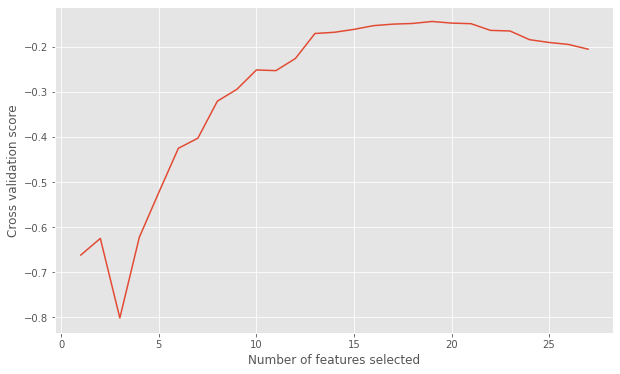

In [69]:
# In our stats method we found that the intercept was not relevant 
# Let's try that feature out in our ML model
model = LinearRegression(fit_intercept=False)
selector = RFECV(model,cv=5)
selector = selector.fit(X_m, y_m)
print(f"Out of {len(X_m.columns)} features, best number of features {selector.n_features_}")

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(X_m.columns) + 1), selector.grid_scores_)
print(X_m.columns[selector.support_].values)
plt.show()

In [70]:
mask = selector.support_
print(f"Best features according to RFE {X_m.columns[mask].values}")

X_m1 = X_m.iloc[:,mask]
# We could have used train test split or cross validation strategies
# for scoring the model but in order to compare with the stats model 
# we will use the whole data
model1 = LinearRegression().fit(X_m1,y_m)
print(f"R2 Score: {model1.score(X_m1,y_m)}")

Best features according to RFE ['X' 'wind' 'rain' 'day_mon' 'day_sat' 'day_sun' 'day_thu' 'day_tue'
 'day_wed' 'month_aug' 'month_dec' 'month_feb' 'month_jan' 'month_jul'
 'month_jun' 'month_mar' 'month_may' 'month_nov' 'month_oct']
R2 Score: 0.05542824436801641


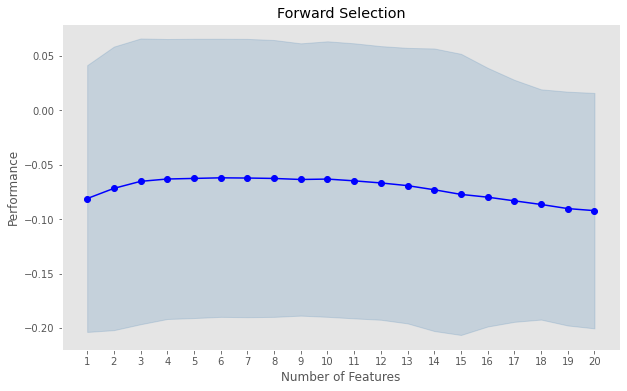

In [71]:
model = LinearRegression(fit_intercept=False)
sfs1 = sfs(model,k_features=20,forward=True,scoring='r2',cv=5)
sfs1.fit(X_m,y_m)
fig = plot_sfs(sfs1.get_metric_dict())
plt.title('Forward Selection')
plt.grid()
plt.show()

In [72]:
print(sfs1.k_features, sfs1.k_feature_names_,sep="\n")

20
('X', 'FFMC', 'ISI', 'RH', 'wind', 'rain', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_mar', 'month_nov', 'month_oct')


In [73]:
index = list(sfs1.k_feature_idx_)
X_m1 = X_m.iloc[:,index]
model1 = LinearRegression().fit(X_m1,y_m)
print(f"R2 Score: {model1.score(X_m1,y_m)}")

R2 Score: 0.054721988510710196


In [76]:
model = LinearRegression(fit_intercept=False)
sfs1 = sfs(model,k_features=6,forward=False,scoring='r2',cv=5)
sfs1.fit(X_m,y_m)
fig = plot_sfs(sfs1.get_metric_dict())
plt.title('Backward Selection')
plt.grid(True)
plt.show()

TypeError: ignored

In [75]:
index = list(sfs1.k_feature_idx_)
print(f"Best features according to RFE: {X_m.columns[index]}")

X_m1 = X_m.iloc[:,index]
model1 = LinearRegression().fit(X_m1,y_m)
print(f"R2 Score: {model1.score(X_m1,y_m)}")

TypeError: ignored

In [77]:
# higher the alpha value, more restriction on the coefficients; 
# lower the alpha > more generalization, coefficients are barely
rr = RidgeCV(cv=5,fit_intercept=False) 
rr.fit(X_m, y_m)
rr.score(X_m,y_m)

0.0605551966881519

In [78]:
rr.alpha_

10.0

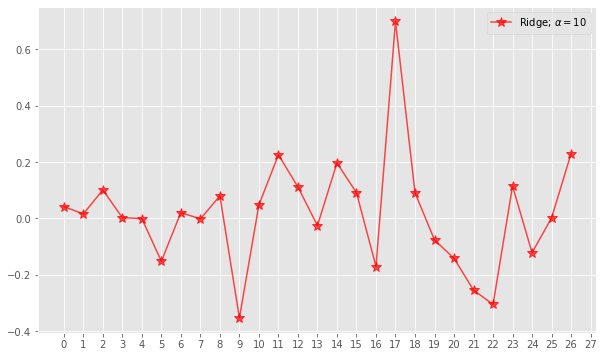

In [79]:
plt.plot(rr.coef_,alpha=0.7,marker='*',markersize=10,color='red',label=r'Ridge; $\alpha =10$') 
plt.grid(True)
plt.xticks(range(0,28,1))
plt.legend()
plt.show()